The goal of this exercise is to implement anomaly detection algorithm. I will be working with a data set containing throughput (in mb/s) and latency (in ms) of response of a servers cluster. I am going to use a Gaussian model because it is reasonable to think that both throughput and latency should follow normal distributions. Then I will be able to classify events that have low probability as anomalies. I will start by reading and visualising the data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X1 = np.genfromtxt('X1.csv', delimiter=',')
X1val = np.genfromtxt('X1val.csv', delimiter=',')
y1val = np.genfromtxt('y1val.csv', delimiter=',')

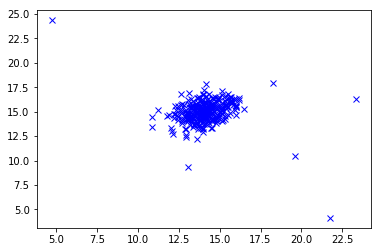

In [6]:
plt.plot(X1[:,0], X1[:, 1], 'bx')

In [14]:
def estimate_gaussian(X):
    return [np.mean(X, axis=0), np.std(X, axis=0, ddof=0)]

mu, sigma = estimate_gaussian(X1)

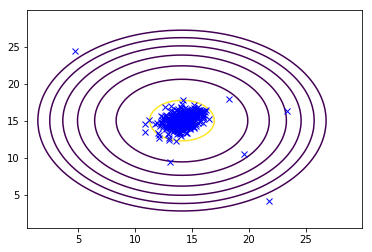

In [70]:
from scipy.stats import norm
x, y = np.meshgrid(np.arange(0.5, 30, 0.1), np.arange(0.5, 30, 0.1))
z = np.multiply(norm(mu[0], sigma[0]).pdf(x), norm(mu[1], sigma[1]).pdf(y))
plt.contour(x, y, z, np.power(10.0, np.arange(-20, 1, 3)))
plt.plot(X1[:,0], X1[:,1], 'bx')

In my model I calculate the probability of the event as a product of probabilites of each feature. This is only true assuming that the probabilities are independent. However in practice it turns out that this approach works well even if the features are not independent. A formally correct approach would be to calculate probability from multivariate normal distribution. Another problem with my approach is that in some cases I would have to manually choose features that would be unusually large or small for anomalies. On the other hand it is computionaly cheaper than using multivariate normal distribution and works well even when the training size is small.

Now that I have my model it is time to choose $\varepsilon$ such that all instances for which $p(x) < \varepsilon$ will be classified as anomalies. To choose the threshold value I will use a cross validation set and $F_1$ score to have some kind of indication of how well the model performs. 

In [94]:
p1 = norm(mu[0], sigma[0]).pdf(X1val[:,0])
p2 = norm(mu[1], sigma[1]).pdf(X1val[:,1])
# Those are the probabilities for the cross validation set.
pval = np.multiply(p1, p2)
def select_threshold(yval, pval):
    step_size = (max(pval) - min(pval)) / 1000
    best_epsilon = 0
    best_F1 = 0
    for epsilon in np.arange(min(pval), max(pval), step_size):
        predictions = pval < epsilon
        tp = np.sum(np.logical_and(predictions == 1, yval == 1), axis=0)
        fp = np.sum(np.logical_and(predictions == 1, yval == 0), axis=0)
        fn = np.sum(np.logical_and(predictions == 0, yval == 1), axis=0)
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    return [best_epsilon, best_F1]
best_epsilon, best_F1 = select_threshold(y1val, pval)
best_epsilon, best_F1

C:\Users\Franek\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


(8.990852779269486e-05, 0.8750000000000001)

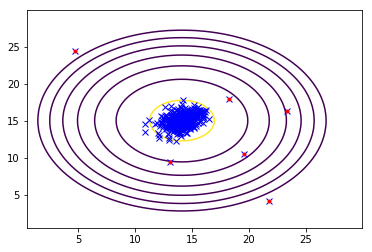

In [98]:
plt.contour(x, y, z, np.power(10.0, np.arange(-20, 1, 3)))
plt.plot(X1[:,0], X1[:,1], 'bx')
pr1 = norm(mu[0], sigma[0]).pdf(X1[:,0])
pr2 = norm(mu[1], sigma[1]).pdf(X1[:,1])
# Those are the probabilities for the cross validation set.
p = np.multiply(pr1, pr2)
plt.plot(X1[p < best_epsilon, 0], X1[p < best_epsilon, 1], 'r.')

All instances marked with a red dot have been classified as anomalies.